# Quantum Teleportation

$\providecommand{\ket}[1]{\left|#1\right\rangle}$
$\providecommand{\bra}[1]{\left\langle#1\right|}$

In this sample we will be looking at using quantum teleportation on Azure Quantum.

To refresh our mind let us review how quantum teleportation works.

We have two parties, Alice and Bob, they would like to share information, and they have an entangled state (usually the Bell state $\frac{1}{\sqrt{2}} (\ket{00} + \ket{11})$). 
If Alice now wishes to transfer quantum information, she will entangle some payload with her qubit and measure her qubit and payload.She will transmit the results of the measurement to Bob, who can use them to reconstruct Alice's payload on his entangled qubit.

In the following we code will implement this operation.

In [1]:
open Microsoft.Quantum.Diagnostics;

In [2]:
operation CreateBellState(alice : Qubit, bob : Qubit) : Unit is Adj + Ctl {
    H(alice);
    CNOT(alice, bob);
}

operation Send(alice : Qubit, payload: Qubit) : (Result, Result) {
    CNOT(payload, alice);
    H(payload);
    return (M(alice), M(payload));
}

operation Receive(bob : Qubit, (cr_x : Result, cr_z : Result)) : Unit {
    if (cr_x == One) { X(bob); }
    if (cr_z == One) { Z(bob); }
}

CreateBellState, Send, Receive

We will now use Q# visualization tools to show the unitary responsible from creating the Bell state.
Printing unitary transformations implemented by operations is a great way to check whether your implementation is mathematically correct (for small operations).

In [3]:
operation ShowBellstate() : Unit {
    DumpOperation(2, qubits => CreateBellState(qubits[0], qubits[1]));
}

ShowBellstate, _b35e7070b5ea46b2bc578f8fd14a6602_ShowBellstate

In [4]:
%simulate ShowBellstate

Real:
[[0.7071067811865477, 0.7071067811865477, 0, 0], 
[0, 0, 0.7071067811865477, -0.7071067811865477], 
[0, 0, 0.7071067811865477, 0.7071067811865477], 
[0.7071067811865477, -0.7071067811865477, 0, 0]]
Imag:
[[0, 0, 0, 0], 
[0, 0, 0, 0], 
[0, 0, 0, 0], 
[0, 0, 0, 0]]

()

Below we will now verify that our teleportation does indeed work correctly.

In order to do this, we will teleport a state of a qubit that we rotate to an unusual angle from Alice to Bob.

We will be using the `DumpRegister` and `AssertQubit` functions from the `Microsoft.Quantum.Diagnostics` to introspect our registers and assert that by the end of the computation the state of Bob's qubit is equivalent to the state of the payload qubit before teleportation.

In [5]:
operation PerformTeleportationOnBellState(alice : Qubit, bob : Qubit, payload : Qubit) : Unit {
    let cr = Send(alice, payload);
    Receive(bob, cr);
}

PerformTeleportationOnBellState

In [6]:
operation TestTeleportation() : Unit {
    use (alice, bob, payload) = (Qubit(), Qubit(), Qubit());
    Ry(1.727, payload);
    DumpRegister((), [payload]);
    CreateBellState(alice, bob);
    PerformTeleportationOnBellState(alice, bob, payload);
    Adjoint Ry(1.727, bob); // Uncompute Bob's qubit. Hence Bob should have a 0 qubit
    AssertQubit(Zero, bob);
}

TestTeleportation

In [7]:
%simulate TestTeleportation

|0⟩	0.6497810284339186 + 0𝑖
|1⟩	0.7601214475906853 + 0𝑖

()

Seeing empirically that our teleportation works, we can proceed to run it on hardware and measure the fidelity.

For this we will recreate our test function but run it multiple times.

In [8]:
open Microsoft.Quantum.Convert;

In [9]:
operation TeleportFidelityHelper() : Result {
    use (alice, bob, payload) = (Qubit(), Qubit(), Qubit());
    Ry(1.727, payload);
    CreateBellState(alice, bob);
    PerformTeleportationOnBellState(alice, bob, payload);
    Adjoint Ry(1.727, bob);
    return M(bob);
}

operation TestFidelity(n : Int) : Double {
    mutable expected = 0;
    for i in 1..n {
        if (TeleportFidelityHelper() == Zero) {
            set expected = expected + 1;
        }
    }
    return IntAsDouble(expected) / IntAsDouble(n);
}

TeleportFidelityHelper, TestFidelity

Let us now compare how the theoretical fidelity compares to the practical fidelity. For this we will first simulate our code and then proceed to run it on Quantinuum hardware through Azure Quantum.

In [ ]:
%simulate TestFidelity n=100

We see that in theory on a perfect machine we'd see perfect fidelity. Now let us try running our work on Azure Quantum.
For that we begin by connecting to our Azure workspace.

In [ ]:
%azure.connect "" location=""

When running jobs on Azure Quantum, before going to real hardware it is recommended to run your code through a validator to make sure you don't waste precious resources on faulty code. `quantinuum.hqs-lt-s2-apival` is the appropriate target for this.

In [ ]:
%azure.target quantinuum.hqs-lt-s2-apival

Let us now submit our job

In [ ]:
%azure.submit TeleportFidelityHelper jobName="Teleporation fidelity API validation"

Now with the confidence that our job will work we can submit it to the simulator. The Quantinuum emulator provided by Azure Quantum differs from the simulator running locally, in that it accurately models noise and behavior of the Quantinuum quantum computer.

In [ ]:
%azure.target quantinuum.hqs-lt-s2-sim

In [ ]:
%azure.submit TeleportFidelityHelper jobName="Teleporation fidelity simulation"

Now we will look into our job and wait for its completion using `%azure.status` and once complete see results using `%azure.output`.

In [ ]:
%azure.status

In [ ]:
%azure.output

Let us now enhance our code by building entanglement swapping. The idea of entanglement swapping is that if Alice and Bob do not have a direct connection but connections to third parties such that a path exists, then each pair of adjacent parties can create Bell states and teleport Alice's second qubit along this path until it reaches Bob.

First we build the base case of entanglement swapping `EntanglementSwap3`, then we proceed to build the general case `EntanglementSwapN`

We will test entanglement swapping with 3 parties by using the Bell pair we create to send a specific qubit state. With the advanced debugging tools of Q# we can introspect that states mid-simulation allowing us to perform this test. To validate that teleportation protocol was implemented correctly, we will use assertion features provided by Q#. Later in this notebook we will test entanglement swapping by checking that Alice and Bob have a Bell state since we will run on real hardware (or accurate simulators thereof) which does not allow such introspection. Validating concepts on small scale using Q# debugging features before proceeding to building full-scale algorithms is a good quantum software development practice.

In [10]:
operation EntanglementSwap3(alice_charlie : Qubit[], charlie_bob : Qubit[]) : (Qubit, Qubit) {
    CreateBellState(alice_charlie[0], alice_charlie[1]);
    CreateBellState(charlie_bob[0], charlie_bob[1]);
    PerformTeleportationOnBellState(charlie_bob[0], charlie_bob[1], alice_charlie[1]);
    ResetAll([alice_charlie[1], charlie_bob[0]]);
    return (alice_charlie[0], charlie_bob[1]);
}

operation TestEntanglementSwap3() : Unit {
    use alice_charlie = Qubit[2];
    use charlie_bob = Qubit[2];
    let (alice, bob) = EntanglementSwap3(alice_charlie, charlie_bob);
    use payload = Qubit();
    Ry(1.727, payload);
    DumpRegister((), [payload]);
    PerformTeleportationOnBellState(alice, bob, payload);
    Adjoint Ry(1.727, bob);
    AssertQubit(Zero, bob);
}

EntanglementSwap3, TestEntanglementSwap3

In [ ]:
%simulate TestEntanglementSwap3

Now let us build entanglement swapping for $n$ parties, given that we have validated the concept for 3 parties. As mentioned above, we will then test that Alice and Bob end up sharing a Bell state.

In [19]:
operation EntanglementSwapN(nParties : Int, qubits : Qubit[]) : (Qubit, Qubit) {
    for i in 0..nParties-1 {
        // Entangle pairs of qubits
        CreateBellState(qubits[2 * i], qubits[2 * i + 1]);
    }
    for i in 1..nParties-1 {
        // Teleport previously teleported qubit 
        PerformTeleportationOnBellState(qubits[2 * i], qubits[2 * i + 1], qubits[2 * i - 1]);
    }
    return (qubits[0], qubits[2 * nParties - 1]);
}

EntanglementSwapN

Let us now test entanglement swapping with 4 qubits locally by teleporting a state again and using Q#'s debugging features.

In [14]:
operation EntanglementSwap4() : (Result) {
    use qubits = Qubit[2 * 4];
    let (q1, qn) = EntanglementSwapN(4, qubits);
    use payload = Qubit();
    let rot = Ry(1.727, _);
    rot(payload);
    DumpRegister((), [payload]);
    PerformTeleportationOnBellState(q1, qn, payload);
    DumpRegister((), [qn]);
    Adjoint rot(qn);
    return M(qn);
}

EntanglementSwap4

In [15]:
%simulate EntanglementSwap4

Entangle 0 1
Entangle 2 3
Entangle 4 5
Entangle 6 7
Teleport 1 to 3
Teleport 3 to 5
Teleport 5 to 7


|0⟩	0.6497810284339186 + 0𝑖
|1⟩	0.7601214475906852 + 0𝑖

|0⟩	0.6497810284339188 + 0𝑖
|1⟩	0.7601214475906855 + 0𝑖

Zero

In [16]:
operation TeleportEntanglementSwapFidelityHelper(nParties : Int) : Result {
    use qubits = Qubit[2 * nParties];
    let (alice, bob) = EntanglementSwapN(nParties, qubits);
    use payload = Qubit();
    let rot = Ry(1.727, _);
    rot(payload);
    PerformTeleportationOnBellState(alice, bob, payload);
    Adjoint rot(bob);
    return M(bob);
}

operation TeleportEntanglementSwapFidelity(n : Int, nParties : Int) : Double {
    mutable success = 0;
    for i in 1..n {
        if (TeleportEntanglementSwapFidelityHelper(nParties) == Zero) {
            set success = success + 1;
        }
    }
    return IntAsDouble(success) / IntAsDouble(n);
}

TeleportEntanglementSwapFidelityHelper, TeleportEntanglementSwapFidelity

Given that we will run on Quantinuum's H1-2, we can run with up to 6 parties as we have 12 qubits available. So let us run one example job.

**Please note that this sample makes use of paid services on Azure Quantum. The cost of running this sample with the provided parameters on Quantinuum in a free trial subscription is approximately 31.8EHQC. This quantity is only an approximate estimate and should not be used as a binding reference. The cost of the service might vary depending on your region, demand and other factors.** 


In [22]:
%simulate TeleportEntanglementSwapFidelity n=100 nParties=6

1

In [23]:
%azure.target quantinuum.hqs-lt-s2-apival

Please call %azure.connect before setting an execution target.


Not connected to any Azure Quantum workspace.

In [ ]:
%azure.submit TeleportEntanglementSwapFidelityHelper nParties=5 jobName="Entanglement Swapping - 6 parties API validation"

In [ ]:
%azure.status

In [ ]:
%azure.output

In [ ]:
%azure.target quantinuum.hqs-lt-s2-sim

In [ ]:
%azure.submit TeleportEntanglementSwapFidelityHelper nParties=5 jobName="Entanglement Swapping - 6 parties"

In [ ]:
%azure.status

In [ ]:
%azure.output

If we were to run this with different numbers of parties, we could graph the results. To not overuse your free credits we did this for you. We show our results in the figure below:

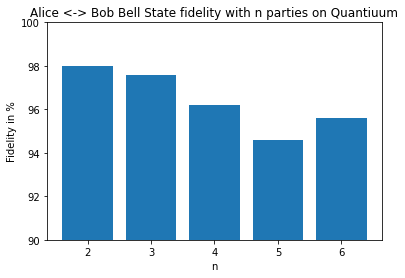



As we can see, there is definitely some noise, and fidelities drop under 95%.
While this might not seem like much, remember that our circuit is extremely small.
This meaning that for larger examples which you can find in other notebooks this effect will be more pronounced.

In the data we also see that (contrary to expectations) $n=5$ has worse fidelity than $n=6$. 
